# We want to create a synthetic time series data set

> Based on the synthetic data generation notebook of the ```afa``` repository by Henrik von Kleist.

In [4]:
%load_ext autoreload
%autoreload 2

In [ ]:

import sys
import os
import pathlib
relative_path_to_afa = '../../afa_github/afa'
#sys.path.insert(0, os.path.abspath(relative_path_to_afa))
sys.path.insert(1, os.path.join(sys.path[0], relative_path_to_afa))
print('CWD:', pathlib.Path(pathlib.Path.cwd()))

import sklearn

# data generation
from afa_datasets.synthetic_data.data_generation_ts import generate_data_ts

# loading/ saving
from data_modelling.clairvoyance_static.datasets.data_loader import CSVLoader, save_dataset
from data_modelling.clairvoyance_static.utils.model_utils import PipelineComposer

In [ ]:
# define directories
data_dir = "dataset/"
dataset_name = "synthetic_1"

# Datageneration

Use sklearn's make-classification function

In [26]:
# df_train, df_test = generate_data_ts(data_dir = data_dir + dataset_name + "/", 
#                                          dataset_name = dataset_name,
#                                          n_features_static  = 4 ,
#                                          n_features_ts  = 10 ,
#                                          n_redundant = 0 ,
#                                          n_informative = 2,
#                                          n_datapts   = 200000,
#                                          n_classes   = 2,
#                                          random_state  = 47,
#                                          test_size   = 0.5)

data_train_ts_df, data_train_static_df, data_test_ts_df, data_test_static_df = generate_data_ts(data_dir = "",
                                        dataset_name = "synthetic_ts_1",
                                        n_features_static  = 2  ,
                                        n_features_ts      = 4  , 
                                        n_timepts   = 50,
                                        n_datapts   = 100, 
                                        test_size = 0.1,
                                        table_style = 'wide',
                                        n_classes   = 2)

# Load the Data

+ First import necessary stuff.
+ Look at simple implementations on how to handle the data
+ Then use ```Dataset``` class from Pytorch to handle the data.

In [2]:
import pandas as pd

Load the data and show the beginning.

In [3]:
path = '/home2/joshua.wendland/Documents/sepsis/toy_dataset/synthetic_ts_1/synthetic_ts_test_data_eav.csv.gz'

df = pd.read_csv(path, compression=None)
df = df.sort_values(by=['id', 'time'], ascending=True, ignore_index=True)  # time was not sorted

print(df.head)


<bound method NDFrame.head of         id  time    X_ts_0    X_ts_1    X_ts_2    X_ts_3      Y_ts
0    id_90     0  0.627422 -0.478959 -0.892121 -0.318527  1.083295
1    id_90     1 -0.448220  0.019303 -0.127440 -0.157412  1.093168
2    id_90     2  0.637957 -0.386629 -0.416992  0.772078  1.026738
3    id_90     3  0.114574 -0.700368  0.415711 -0.584559  0.891013
4    id_90     4  0.318873  0.112828  0.575051  0.149870  0.813476
..     ...   ...       ...       ...       ...       ...       ...
495  id_99    45  0.033853  0.889838  0.867147 -0.226947  0.981591
496  id_99    46 -0.883889  1.506605  0.732750  0.466535  0.846787
497  id_99    47  1.267585 -0.623064  0.034502 -0.162447  0.901342
498  id_99    48 -1.544032  0.310212  1.469414  0.941757  0.912135
499  id_99    49  1.052585 -0.451113  1.395424 -0.229020  0.822956

[500 rows x 7 columns]>


Group the data according to each ```id``` of the time series. 
This is easily done by using the ```groupby()``` method on the DataFrame. This transforms the data into the structure of:

| Group Name (or ID) | Pandas Series   |  
| ------------------ | --------------- |
| id_0              | Series of id_0 |  
| id_1              | Series of id_1 |  
| ...              | ... |  

To receive a certain Series ID ```i``` we just need to call ```df_grouped[i, 0]```.
To receive the corresponding Series data we call ```df_grouped[i, 1]```.

In [110]:
# Group by 'id'
df_grouped = pd.DataFrame(df.groupby('id'))
# Get rid of the 'id'-column in each group
for x in df_grouped.iloc[:,1]:
    x.drop(columns=['id'], inplace=True)
    
print(df_grouped.iloc[-1,1].head())
print(df_grouped.iloc[-1,1].tail())

     time    X_ts_0    X_ts_1    X_ts_2    X_ts_3      Y_ts
450     0  2.715997  0.325934 -0.486907 -2.543788  1.054109
451     1  1.526065  1.121756 -0.514032 -0.396498  0.764149
452     2 -0.505807  0.863921  0.798771 -0.444982  1.008917
453     3  0.788786  0.825285  0.303744 -1.426538  0.986686
454     4  0.219992 -0.188746 -0.861897 -0.611712  0.816993
     time    X_ts_0    X_ts_1    X_ts_2    X_ts_3      Y_ts
495    45  0.033853  0.889838  0.867147 -0.226947  0.981591
496    46 -0.883889  1.506605  0.732750  0.466535  0.846787
497    47  1.267585 -0.623064  0.034502 -0.162447  0.901342
498    48 -1.544032  0.310212  1.469414  0.941757  0.912135
499    49  1.052585 -0.451113  1.395424 -0.229020  0.822956


In [151]:
import numpy as np


X = df_grouped.drop(columns=0)
x = X.loc[1]
x

1        time    X_ts_0    X_ts_1    X_ts_2    X_ts...
Name: 1, dtype: object

## Using Pytorch class ```Dataset``` and ```Dataloader```

+ First import necessary modules.
+ Implement the ```Dataset``` class.

### `Dataset`

Loading the Toydataset is easy, just ...
+ give the correct path,
+ enter all missingness criteria. Currently supported is `None` (=No missingness) and `mcar` (=Missing Completely at Random). 

> Note: The missingness pattern is created by the `pycorruptor` package.

In [34]:
import data_utils

path = '/home2/joshua.wendland/Documents/sepsis/toy_dataset/synthetic_ts_1/synthetic_ts_test_data_eav.csv.gz'
missingness = 'mcar'
missingness_rate = 0.1
missingness_values = -1
dataset = data_utils.ToyDataset(path, 
                                missingness=missingness, 
                                missingness_rate=missingness_rate, 
                                missingness_value=missingness_values
)

### `DataLoader`

Problems with Dataloader:
+ If there is an error and `num_workers!=0`, try setting it to `0`.
+ If there is an error and `shuffle=True`, try setting it to `False`. (Fixed)

In [35]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=dataset, batch_size=8, shuffle=True, num_workers=0)


Test the `DataLoader` by looking at some samples.

In [37]:
import torch
# convert to an iterator and look at one random sample
dataiter = iter(train_loader)
data = next(dataiter)
X, missing_mask, time, Y = list(data)
print('features:\n', X.shape)
print('Missingness: ', f'{float(torch.sum(X == missingness_values) /  torch.numel(X)):.2f}')
for d in data:
    print(type(d), d.dtype, d.shape)

features:
 torch.Size([8, 50, 5])
Missingness:  0.10
<class 'torch.Tensor'> torch.float32 torch.Size([8, 50, 5])
<class 'torch.Tensor'> torch.float32 torch.Size([8, 50, 5])
<class 'torch.Tensor'> torch.float32 torch.Size([8, 50])
<class 'torch.Tensor'> torch.float32 torch.Size([8, 50, 5])


Let's split the dataset into training and validation set.

> TODO!


# Make my own data

Generating synthetic time series data with four variables representing:
+ Noise
+ Trend (+ Noise)
+ Seasonality (+ Noise )
+ Trend + Seasonality (+ Noise)

The generated data will be saved in the same way as the data created above. It will have the columns `'id', 'time', 'Noise', 'Trend', 'Seasonality', 'Trend + Season'`. During generation of data it will be handled as a `pandas.DataFrame` object and then saved as a `*.csv.gz` file under the specified location.

The four parts of data:
+ The **noise** part is by sampling from a normal distribution with $\mu=0$ and $\sigma=1$.
+ The **trend** part consists of $m \cdot x(t) + n + \text{noise}$ , where $m,n$ are sampled from the same distribution as the noise.
+ The **seasonality** part has its frequency and amplitude drawn form a uniform distribution and then computes to $\text{amplitude} \cdot \sin{(x(t) \cdot \text{frequency})} + \text{noise} \cdot \epsilon$, where $\epsilon$ is drawn from the standard normal distribution.
+ The **trend+seasonality** part is computed via $m \cdot \text{trend} + n + \text{seasonality} + \text{noise} \cdot \epsilon$, where $m, n, \epsilon$ have been drawn independently from the previous parts.

In [228]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [231]:
def generate_ts_sample(series_length=100):
    """ There are exactly 4 cases: noise, trend, seasonality, trend + seasonality"""
    # for each time series: noise, trend, seasonality, trend + seasonality
    time = np.arange(series_length) + np.random.randint(-100,100) # add a random shift
    # noise
    noise = np.random.randn(series_length)
    # trend
    m = np.random.rand()  # slope
    n = np.random.rand()  # y-axis at x=0
    trend = m * time + n + noise
    # seasonality
    frequency = np.random.uniform(0.5,1)
    amplitude = np.random.uniform(1, 10)
    seasonality = amplitude * np.sin(time * frequency) + noise * np.random.rand()
    # trend + seasonality
    m = np.random.uniform(0.1,3)   # slope
    n = np.random.rand() * 100  # y-axis at x=0
    mu = 1
    sigma = 0.1
    trend_season = m * trend + n + seasonality  + np.random.normal(mu, sigma, series_length) * noise

    return time, noise, trend, seasonality, trend_season
    


def genereate_ts_dataset(samples, series_length, save_path=None):
    """Creates Time series dataset with four variables. 

    Args:
        samples (int): The number of individual time series, that comprise the dataset.
        series_length (int): The length of every series.
    """
    columns = ['id', 'time', 'Noise', 'Trend', 'Seasonality', 'Trend + Season']
    df = pd.DataFrame(columns=columns)
    time_series_list = list()
    time_series_list.append(df)
    for i in tqdm(range(samples)):
        # create the time series
        time, noise, trend, seasonality, trend_season = generate_ts_sample(series_length)
        time = np.arange(series_length)
        data = np.stack((time, noise, trend, seasonality, trend_season), axis=1)
        # create the corresponding id
        id = 'id_' + str(i)
        # convert into dataframe
        df_temp = pd.DataFrame(data=data ,columns=columns[1:])
        df_temp['id'] = id
        # add to list
        time_series_list.append(df_temp)
    # combine
    df = pd.concat(time_series_list, ignore_index=True)

    if save_path is not None:
        print(f'Saving dataset under {save_path}\nMake sure to have a *.csv.gz file ending.')
        df.to_csv(save_path, sep=",", compression=None, index=False)
    return df

In [1]:
from toy_dataset import time_series_generation

generate_ts_sample = time_series_generation.generate_ts_sample

/home2/joshua.wendland/Documents/sepsis/sepsis_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttributeError: module 'toy_dataset.time_series_generation' has no attribute 'generate_ts_sample'

In [233]:
series_length = 50
# train dataset
save_path = '/home2/joshua.wendland/Documents/sepsis/toy_dataset/synthetic_ts_4types_50000/synthetic_ts_train_40000.csv.gz'
samples = 40000
# validation set
df = genereate_ts_dataset(samples, series_length, save_path=save_path)
save_path = '/home2/joshua.wendland/Documents/sepsis/toy_dataset/synthetic_ts_4types_50000/synthetic_ts_validation_5000.csv.gz'
samples = 5000
df = genereate_ts_dataset(samples, series_length, save_path=save_path)
# test set
save_path = '/home2/joshua.wendland/Documents/sepsis/toy_dataset/synthetic_ts_4types_50000/synthetic_ts_test_5000.csv.gz'
samples = 5000
df = genereate_ts_dataset(samples, series_length, save_path=save_path)

100%|██████████| 40000/40000 [00:09<00:00, 4250.05it/s]


Saving dataset under /home2/joshua.wendland/Documents/sepsis/toy_dataset/synthetic_ts_4types_50000/synthetic_ts_train_40000.csv.gz
Make sure to have a *.csv.gz file ending.


100%|██████████| 5000/5000 [00:01<00:00, 4717.95it/s]


Saving dataset under /home2/joshua.wendland/Documents/sepsis/toy_dataset/synthetic_ts_4types_50000/synthetic_ts_validation_5000.csv.gz
Make sure to have a *.csv.gz file ending.


100%|██████████| 5000/5000 [00:01<00:00, 4760.67it/s]


Saving dataset under /home2/joshua.wendland/Documents/sepsis/toy_dataset/synthetic_ts_4types_50000/synthetic_ts_test_5000.csv.gz
Make sure to have a *.csv.gz file ending.


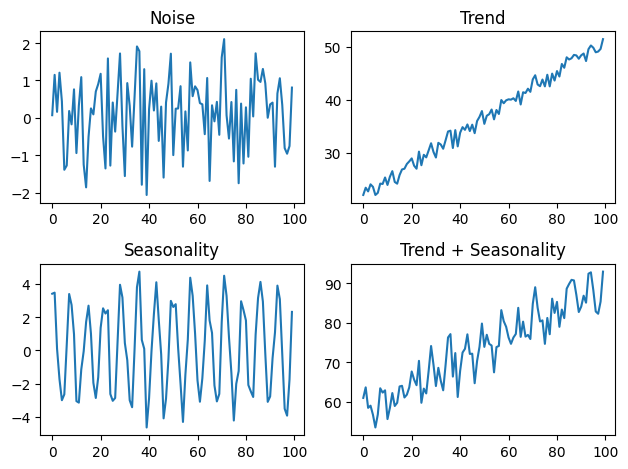

In [208]:
time, noise, trend, seasonality, trend_season = generate_ts_sample()

fig = plt.figure()
fig.add_subplot(221)
plt.plot(np.arange(100), noise)
plt.title('Noise')
fig.add_subplot(222)
plt.title('Trend')
plt.plot(np.arange(100), trend)
fig.add_subplot(223)
plt.title('Seasonality')
plt.plot(np.arange(100), seasonality)
fig.add_subplot(224)
plt.title('Trend + Seasonality')
plt.plot(np.arange(100), trend_season)
plt.tight_layout()